In [1]:
import pandas as pd
from pybedtools import BedTool as BT

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
# This saves fonts as fonts in the svg and not as shapes
plt.rcParams['svg.fonttype'] = 'none'

import numpy as np
from scipy.stats import mannwhitneyu as MWU

import warnings
warnings.filterwarnings('ignore')

## Data Load

We assign a BASAL region to each gene, it starts from its TSS and extends 5kb upstream and 1kb downstream, or untill it encounters another TSS.

For the GREAT region, we extend the BASAL region UP TO 1Mb in each way, or until a BASAL region of another gene is encountered.    
     
Here, we load and use the GREAT regions

In [2]:
greg = {}

greg['Dre'] = pd.read_csv("./data/genomic_regions/GREAT_dre.bed", sep='\t', header=None)
greg['Dre'].columns = ['chrom','start','end','geneID','score','strand']
greg['Dre']['score'] = greg['Dre']['end'] - greg['Dre']['start']

greg['Bla'] = pd.read_csv("./data/genomic_regions/GREAT_bla.bed", sep='\t', header=None)
greg['Bla'].columns = ['chrom','start','end','geneID','score','strand']
greg['Bla']['score'] = greg['Bla']['end'] - greg['Bla']['start']

greg['Ola'] = pd.read_csv("./data/genomic_regions/GREAT_ola.bed", sep='\t', header=None)
greg['Ola'].columns = ['chrom','start','end','geneID','score','strand']
greg['Ola']['score'] = greg['Ola']['end'] - greg['Ola']['start']

greg['Mmu'] = pd.read_csv("./data/genomic_regions/GREAT_mmu.bed", sep='\t', header=None)
greg['Mmu'].columns = ['chrom','start','end','geneID','score','strand']
greg['Mmu']['score'] = greg['Mmu']['end'] - greg['Mmu']['start']

print( [(k,len(v)) for k,v in greg.items()])

[('Dre', 20053), ('Bla', 20569), ('Ola', 15978), ('Mmu', 18842)]


In [3]:
greg['Mmu'].head()

,chrom,start,end,geneID,score,strand
0,chr1,2670503,4359310,ENSMUSG00000051951,1688807,-
1,chr1,3676503,4495409,ENSMUSG00000025900,818906,-
2,chr1,4365319,4784706,ENSMUSG00000025902,419387,-
3,chr1,4501418,4802819,ENSMUSG00000033845,301401,-
4,chr1,4790715,4852810,ENSMUSG00000025903,62095,+


In [4]:
stages = {}
stages['Bla'] = ['8','15','36','60']
stages['Dre'] = ["dome","shield","80epi","8som","24h","48h"]
stages['Ola'] = ["dome","shield","8som","24h","48h"]
stages['Mmu'] = ['DE','ESC']

### The ATAC-seq peaks

As determined by the idr "pipeline", see more in the peak-calling notebook

In [5]:
pre_ = './data/atac_peaks/'

peak_beds = {}

peak_beds['Dre'] = [ (BT("{}zebra_danRer10_{}_idrpeaks.bed".format(pre_,x))
                    .sort()
                    )for x in stages['Dre']]
peak_beds['Bla'] = [(BT("{}amphi_{}_idrpeaks.bed".format(pre_,x))
                     .sort()
                     ) for x in stages['Bla']]
peak_beds['Ola'] = [ (BT("{}medaka_{}_idrpeaks.bed".format(pre_,x))
                    .sort()
                    )for x in stages['Ola']]
peak_beds['Mmu'] = [ (BT("{}mouse_{}_idrpeaks.bed".format(pre_,x))
                    .sort()
                    )for x in stages['Mmu']]


### Grouping of genes into homologous-families       

We have in our disposal a precomputed table where genes of various species
are separated into homologous families.

Each row is a family, each column a species. 
The paralogues of each species are separated with ":" so when we load this dataset
we split the strings into lists.

We also create a second dataframe "genefamsC" which has the same index and shape as the first one,
but contains the count of genes in each cell.

In [6]:
genefams = pd.read_csv("./data/gene_families_table.tsv",
                      sep='\t')
genefams = genefams.applymap(lambda x: x.split(":") if x==x else x)

genefamsC = genefams.applymap(lambda x: len(x) if x==x else 0)

In [7]:
genefamsC.head()

,Bbe,Bla,Cmi,Dre,Gga,Hsa,Mmu,Ola,Sko,Spu,Xtr,Dme
0,1,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,1,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0
3,28,36,6,9,1,4,4,3,61,8,16,0
4,1,1,0,0,0,0,0,0,0,0,0,0


In [8]:
# Make some masks for the dataframe
mask_oto = (genefamsC['Bla']==1) & (genefamsC['Dre']==1)  # 1-1
mask_ottw = (genefamsC['Bla']==1) & (genefamsC['Dre']==2) # 1-2
mask_otth = (genefamsC['Bla']==1) & (genefamsC['Dre']==3) # 1-3
mask_otfo = (genefamsC['Bla']==1) & (genefamsC['Dre']==4) # 1-4

masks = [mask_oto, mask_ottw,mask_otth,mask_otfo]
titles = ['1-1','1-2','1-3','1-4']

# then some sets
oto_genes = genefams.loc[mask_oto,['Bla','Dre','Mmu','Ola']]
oto_genes = set([x for y in oto_genes.values.flatten() if y==y for x in y])
ottw_genes = genefams.loc[mask_ottw,['Bla','Dre','Mmu','Ola']]
ottw_genes = set([x for y in ottw_genes.values.flatten() if y==y for x in y])
otth_genes = genefams.loc[mask_otth,['Bla','Dre','Mmu','Ola']]
otth_genes = set([x for y in otth_genes.values.flatten() if y==y for x in y])
otfo_genes = genefams.loc[mask_otfo,['Bla','Dre','Mmu','Ola']]
otfo_genes = set([x for y in otfo_genes.values.flatten() if y==y for x in y])

# and use the sets to categorize the genes
def categorize(x):
    if x in oto_genes:
        return '1-1'
    elif x in ottw_genes:
        return '1-2'
    elif x in otth_genes:
        return '1-3'
    elif x in otfo_genes:
        return '1-4'
    else:
        return 'nop'

In [9]:
bedfields = ['chrom','start','end','name','score','strand']
big = {}

big['Dre'] = BT().from_dataframe(greg['Dre']).sort()
for bee in peak_beds['Dre']:
    big['Dre'] = big['Dre'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
big['Dre'] = big['Dre'].to_dataframe()
big['Dre'].columns = bedfields + stages['Dre']

# the other species:
big['Bla'] = BT().from_dataframe(greg['Bla']).sort()
for bee in peak_beds['Bla']:
    big['Bla'] = big['Bla'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
big['Bla'] = big['Bla'].to_dataframe()
big['Bla'].columns = bedfields + stages['Bla']

big['Ola'] = BT().from_dataframe(greg['Ola']).sort()
for bee in peak_beds['Ola']:
    big['Ola'] = big['Ola'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
big['Ola'] = big['Ola'].to_dataframe()
big['Ola'].columns = bedfields + stages['Ola']

big['Mmu'] = BT().from_dataframe(greg['Mmu']).sort()
for bee in peak_beds['Mmu']:
    big['Mmu'] = big['Mmu'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
big['Mmu'] = big['Mmu'].to_dataframe()
big['Mmu'].columns = bedfields + stages['Mmu']

In [10]:
big['Dre'].sample(5)

,chrom,start,end,name,score,strand,dome,shield,80epi,8som,24h,48h
8558,chr2,24666594,24712432,ENSDARG00000076265,45838,-,5,5,4,4,3,5
16325,chr5,71592469,71604749,ENSDARG00000102657,12280,+,6,4,5,4,4,4
19869,chrUn_KN149842v1,0,11426,ENSDARG00000100873,11426,+,2,1,1,1,1,2
12350,chr24,25041723,25059837,ENSDARG00000091835,18114,+,1,1,1,1,1,1
15589,chr5,25046876,25075695,ENSDARG00000056386,28819,-,1,0,2,1,2,2


In [11]:
# set the gene ID as index in all dataframes of 'big'
big_ind = {}
for k,v in big.items():
    big_ind[k] = v.set_index('name')
    big_ind[k].columns = [str(x) for x in big_ind[k].columns]

In [12]:

dd_dre = big_ind['Dre'].copy()
dd_dre['category'] = dd_dre.index.to_series().map(categorize)
# dd_dre = dd_dre[dd_dre.category != 'nop']
dd_dre['species'] = 'dre'
dd_dre = dd_dre[stages['Dre']+['category','species']]
dd_dre.columns = stages['Dre']+['category','species']

dd_ola = big_ind['Ola'].copy()
dd_ola['category'] = dd_ola.index.to_series().map(categorize)
# dd_ola = dd_ola[dd_ola.category != 'nop']
dd_ola['species'] = 'ola'
dd_ola = dd_ola[stages['Ola']+['category','species']]
dd_ola.columns = stages['Ola']+['category','species']

dd_bla = big_ind['Bla'].copy()
dd_bla['category'] = dd_bla.index.to_series().map(categorize)
# dd_bla = dd_bla[dd_bla.category != 'nop']
dd_bla['species'] = 'bla'
dd_bla = dd_bla[stages['Bla']+['category','species']]
dd_bla.columns = stages['Bla']+['category','species']

dd_mmu = big_ind['Mmu'].copy()
dd_mmu['category'] = dd_mmu.index.to_series().map(categorize)
# dd_mmu = dd_mmu[dd_mmu.category != 'nop']
dd_mmu['species'] = 'mmu'
dd_mmu = dd_mmu[stages['Mmu']+['category','species']]
dd_mmu.columns = stages['Mmu']+['category','species']

In [13]:
# then melt the DFs from each species and concatenate those
TOPLOT = pd.concat([pd.melt(dd_dre, id_vars=['category','species']),
            pd.melt(dd_bla, id_vars=['category','species']),
            pd.melt(dd_ola, id_vars=['category','species'])
            
                   ])
TOPLOT.columns = ['category','species','stage','count']
TOPLOT.head(2)

,category,species,stage,count
0,nop,dre,dome,0
1,nop,dre,dome,0


In [14]:
def boxplot_pvals(data, x,x_anq,x_targs,y,hue,hue_order):
    for targetx in x_targs:
        for huel in hue_order:
            m1 = (data[x]==x_anq)
            mh = data[hue] == huel
            m2 = (data[x]==targetx)
            print(targetx, huel, MWU( data.loc[mh & m2, y].values, data.loc[mh & m1, y].values, alternative='greater' ).pvalue)

def boxplot_pvals_nohue(data, x,x_anq,x_targs,y):
    for targetx in x_targs:
            m1 = (data[x]==x_anq)
            m2 = (data[x]==targetx)
            print(targetx, MWU( data.loc[m2, y].values, data.loc[ m1, y].values, alternative='greater' ).pvalue)


# Fig. 5 a

dre 0.0


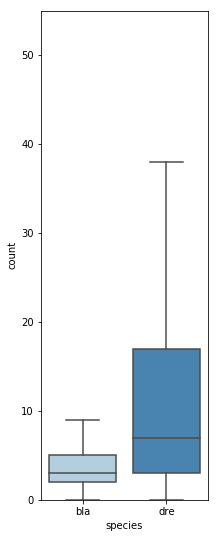

In [21]:
TP = pd.concat(
               [TOPLOT[ (TOPLOT.species=='dre') & (TOPLOT.stage=='8som') & (TOPLOT.category!='nop')],
                TOPLOT[ (TOPLOT.species=='bla') & (TOPLOT.stage=='15') & (TOPLOT.category!='nop')]
               ])


plt.figure(figsize=(3,9))


sns.boxplot(data = TP, 
            
            x='species',
            y='count',
            order=['bla','dre'],
           fliersize=0, palette='Blues',
            
           )
        
plt.ylim((0,55))
plt.legend(loc='upper left')

boxplot_pvals_nohue(TP, 'species','bla',['dre'],'count')

# Fig. 5 b

dre 1-1 0.0
dre 1-2 1.40745687909e-140
dre 1-3 3.49127570804e-61
dre 1-4 2.65469337834e-31


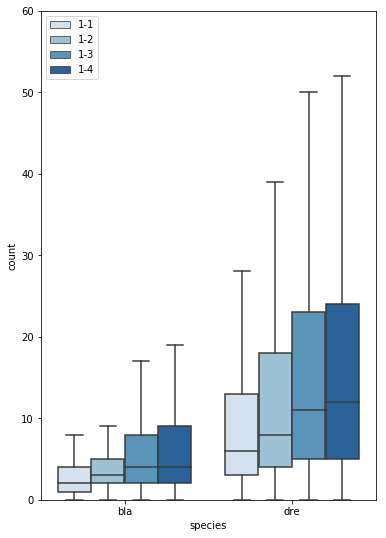

In [19]:
TP = pd.concat(
               [TOPLOT[ (TOPLOT.species=='dre') & (TOPLOT.stage=='24h') & (TOPLOT.category!='nop')],
                TOPLOT[ (TOPLOT.species=='bla') & (TOPLOT.stage=='36') & (TOPLOT.category!='nop')]
               ])

plt.figure(figsize=(6,9))


sns.boxplot(data = TP,  
            x='species',
            order=['bla','dre'],
            y='count',
            hue='category',
            hue_order=['1-1','1-2','1-3','1-4'],
           fliersize=0, palette='Blues'            
           )
        
plt.ylim((0,60))
plt.legend(loc='upper left')

boxplot_pvals(TP, 'species','bla',['dre'],'count','category',['1-1','1-2','1-3','1-4'])

# Fig. 5 c    
For this, we need to choose the max and min gene per gene family so we'll need to go through our data again:

In [22]:
lot = {}
lot['Dre'] = []
lot['Bla'] = []

for mask,title in zip(masks, titles):
    for i,row in genefams.loc[mask,['Bla','Dre']].iterrows():
        for spec in ['Bla','Dre']:
            try:
                lgl = row[spec]
                if lgl == lgl:
                    slaice = big_ind[spec].loc[lgl, stages[spec]]
                    slaice = pd.concat([slaice.min(),slaice.max()], axis=1)
                    slaice.columns = ['min','max']
                    slaice['stage'] = spec + "_" + slaice.index.values
                    slaice = pd.melt(slaice, id_vars=['stage'])
                    slaice['title'] = title
                    
                    lot[spec].append( slaice )
            except:
                pass
lot['Dre'] = pd.concat(lot['Dre'])
lot['Bla'] = pd.concat(lot['Bla'])



bigmelt3 = pd.concat([lot['Dre']
                     , lot['Bla']])

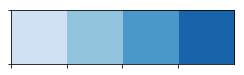

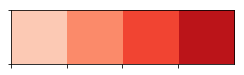

In [23]:
# a hand-made palette
bcp = sns.color_palette('Blues',4)
sns.palplot(bcp)
rcp = sns.color_palette('Reds',4)
sns.palplot(rcp)
mycp = {
#  '1-1max':(0.8141176470588235, 0.883921568627451, 0.9498039215686275),
    '1-1max':(0.9027451 ,  0.83764706,  0.82901961),
    '1-1min':(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),
    '1-2max':(0.5796078431372549, 0.7701960784313725, 0.8737254901960784),
    '1-2min':(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),
    '1-3max':(0.2909803921568628, 0.5945098039215686, 0.7890196078431373),
    '1-3min':(0.9466666666666667, 0.26823529411764707, 0.19607843137254902),
    '1-4max':(0.09019607843137256, 0.39294117647058824, 0.6705882352941177),
    '1-4min':(0.7364705882352941, 0.08, 0.10117647058823528),
    '_':(0,0,0)}

In [24]:
foo = bigmelt3[bigmelt3.stage.isin(oMF2)].copy()
foo['nf'] = foo.title + foo.variable

foo['norm'] = 0

(0, 60)

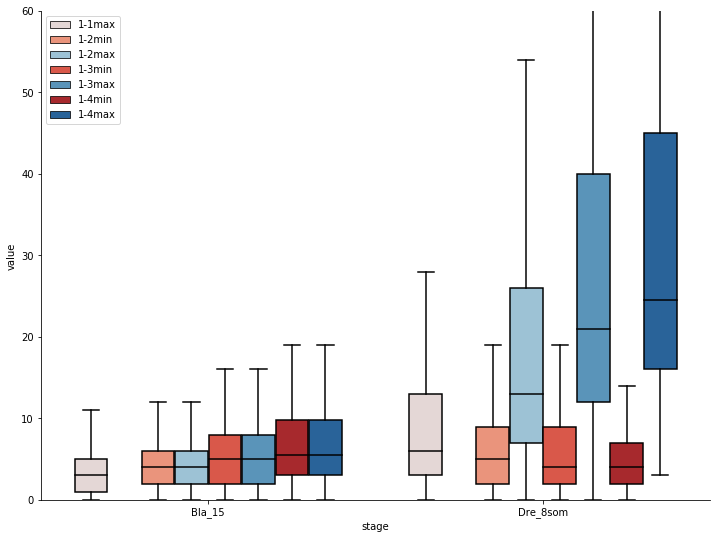

In [36]:
toplot = foo.copy()
toplot['hew'] = toplot.title  + toplot.variable

plt.figure(figsize=(12,9))

g = sns.boxplot(
            
            x="stage",
            y="value",
            hue="hew",
            fliersize=0,
            hue_order=['1-1max','_','1-2min','1-2max','1-3min','1-3max','1-4min','1-4max'],
            palette = mycp,
            order=['Bla_15','Dre_8som'],
            data=toplot
            )
plt.legend(loc='upper left')
sns.despine()

plt.ylim((0,60))

In [37]:
# some pvalues
boxplot_pvals(toplot, 'stage','Bla_15',['Dre_8som'],'value','hew',['1-1max','_','1-2min','1-2max','1-3min','1-3max','1-4min','1-4max'])

Dre_8som 1-1max 3.99445058218e-278
Dre_8som _ 1.0
Dre_8som 1-2min 1.026267369e-10
Dre_8som 1-2max 1.36743541975e-178
Dre_8som 1-3min 0.440124060257
Dre_8som 1-3max 4.79126396113e-103
Dre_8som 1-4min 0.998286751524
Dre_8som 1-4max 1.7974330912e-61


/home/ska/tools/py3_venv/lib/python3.6/site-packages/scipy/stats/stats.py:4879: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


# Fig. 5 k 

In [68]:
fate_dict_zebra = dict(pd.read_csv("./data/gene_fates/Gene_types-Dre-v3.txt", sep='\t',header=None).set_index(0)[1])
fate_dict_mouse = dict(pd.read_csv("./data/gene_fates/Gene_types-Mmu-v3.txt", sep='\t',header=None).set_index(0)[1])

FATE_ORDER = ['REDUNDANT','SUBFUNCT','SPEC_EQUAL', 'SPEC_MILD','SPEC_STRONG']

In [55]:
bedfile = BT().from_dataframe(greg['Dre']).sort()

df = bedfile.intersect(BT("./data/atac_peaks/zebra_danRer10_merged_idrpeaks.bed"), c=True).to_dataframe()



***** WARNING: File /tmp/pybedtools.3n54uxkf.tmp has inconsistent naming convention for record:
MT	0	4804	ENSDARG00000063895	4804	+

***** WARNING: File /tmp/pybedtools.3n54uxkf.tmp has inconsistent naming convention for record:
MT	0	4804	ENSDARG00000063895	4804	+



In [57]:
df['fate'] = df['name'].map(fate_dict_zebra)

In [61]:
toplot = df[['thickStart','fate']].dropna()

(0, 90)

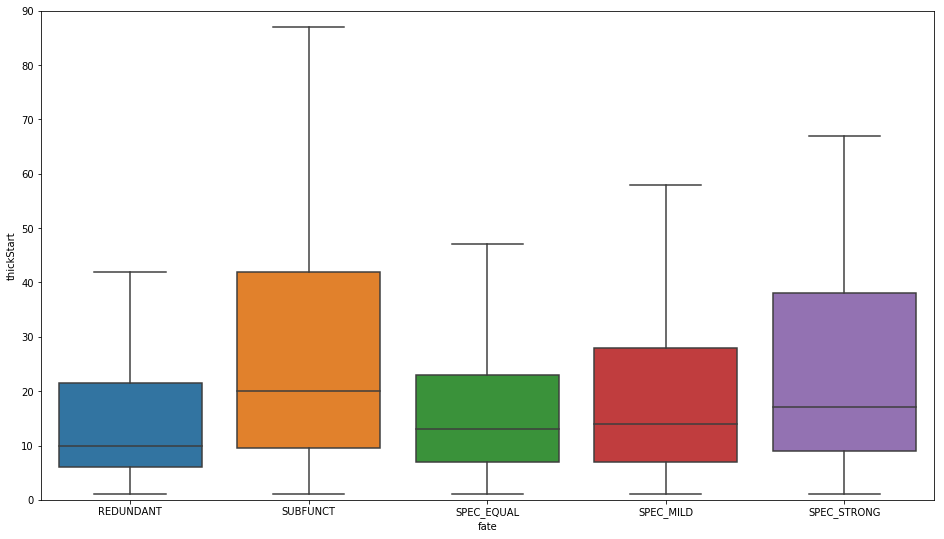

In [66]:
plt.figure(figsize=(16,9))
sns.boxplot( data=dd_dre, 
           y='8som',
           x='category',
        fliersize=0,
            order=FATE_ORDER
           )


plt.ylim((0,55))